In [1]:
!pip install pandas numpy antropy tqdm matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
from antropy import sample_entropy, perm_entropy, app_entropy, lziv_complexity
from scipy.signal import decimate
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset

In [3]:
# --- PARAMETERS ---
PARQUET_FILE = 'eeg_dataset_cleaned.parquet'

ORIGINAL_FS = 256
DOWNSAMPLE_FACTOR = 16
WINDOW_SEC = 5
NUM_CHANNELS = 5

In [4]:
print("Loading data...")
df = pd.read_parquet(PARQUET_FILE)
channels = df.columns[:NUM_CHANNELS].tolist()

Loading data...


In [5]:
print("Downsampling...")
df_down = pd.DataFrame()
for ch in channels:
    df_down[ch] = decimate(df[ch].values, DOWNSAMPLE_FACTOR, ftype='fir', zero_phase=True)

fs_new = ORIGINAL_FS // DOWNSAMPLE_FACTOR
window_size = fs_new * WINDOW_SEC
num_windows = len(df_down) // window_size
print(f"Total windows: {num_windows}")

Downsampling...
Total windows: 4567


# Custom Higuchi FD function

In [6]:
def higuchi_fd(signal, kmax=10):
    N = len(signal)
    L = []
    x = signal
    for k in range(1, kmax+1):
        Lk = []
        for m in range(k):
            Lmk = 0
            nmax = (N - m - 1)//k
            for i in range(1, nmax):
                Lmk += abs(x[m + i*k] - x[m + (i-1)*k])
            Lmk = Lmk * (N - 1) / (k * nmax * k) if nmax != 0 else 0
            Lk.append(Lmk)
        L.append(np.mean(Lk))
    lnL = np.log(L)
    lnk = np.log(1. / np.arange(1, kmax+1))
    (p, _) = np.polyfit(lnk, lnL, 1)
    return p

# Safe compute wrapper

In [7]:
def safe_compute(func, signal, *args, **kwargs):
    try:
        return func(signal, *args, **kwargs)
    except:
        return np.nan

# Feature Extraction

In [8]:
print("Extracting non-linear features...")
results = []
for i in tqdm(range(num_windows)):
    start = i * window_size
    end = start + window_size
    win = df_down.iloc[start:end]
    row = {"window": i}
    for ch in channels:
        sig = win[ch].values
        row[f"{ch}_HiguchiFD"] = safe_compute(higuchi_fd, sig)
        row[f"{ch}_SampleEntropy"] = safe_compute(sample_entropy, sig)
        row[f"{ch}_ApproxEntropy"] = safe_compute(app_entropy, sig)
        row[f"{ch}_PermEntropy"] = safe_compute(perm_entropy, sig, normalize=True)
        row[f"{ch}_LZC"] = safe_compute(lziv_complexity, sig)
    results.append(row)

features_df = pd.DataFrame(results)
print("Feature extraction complete!")

Extracting non-linear features...


100%|██████████| 4567/4567 [00:30<00:00, 148.63it/s]

Feature extraction complete!


# Plotting

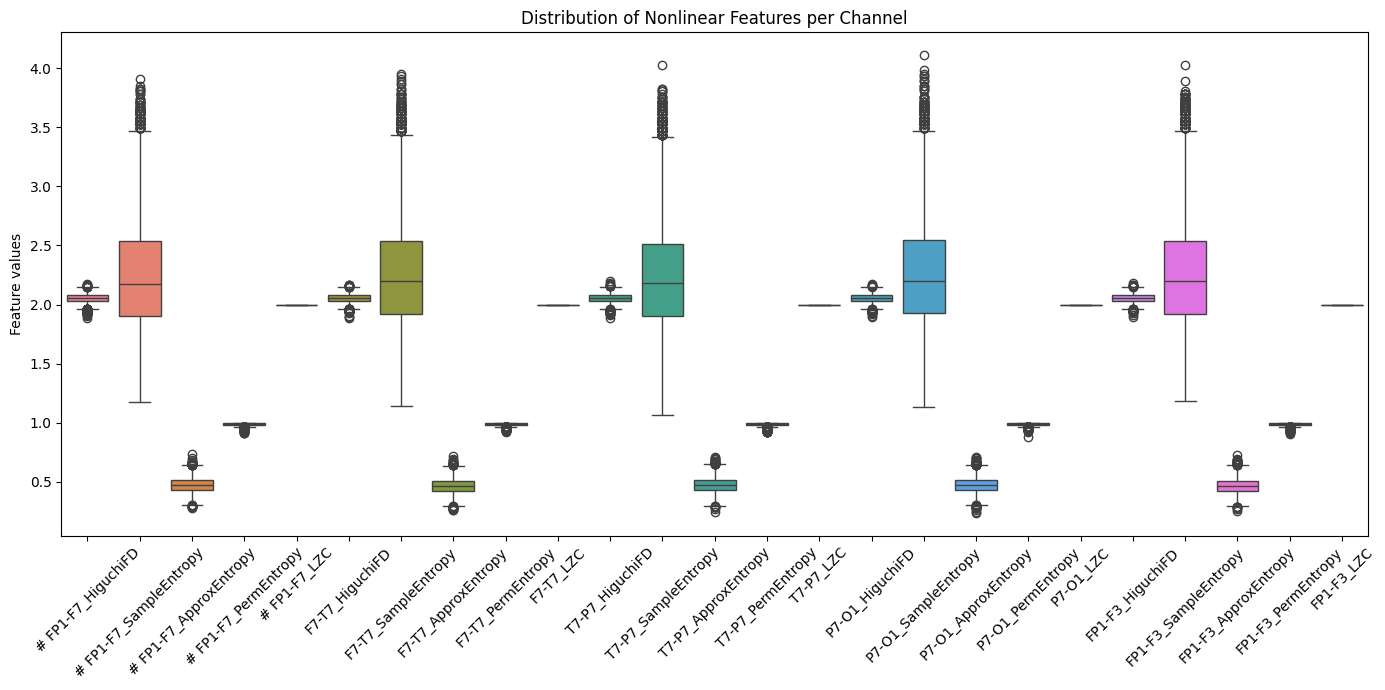

In [9]:
features_only = features_df.drop(columns=['window'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=features_only)
plt.title('Distribution of Nonlinear Features per Channel')
plt.xticks(rotation=45)
plt.ylabel('Feature values')
plt.tight_layout()
plt.savefig('boxplot_nonlinear_features.png')
plt.show()

/tmp/ipykernel_287/669885552.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(features_only[col].dropna(), label=col, fill=True, alpha=0.4)
/tmp/ipykernel_287/669885552.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(features_only[col].dropna(), label=col, fill=True, alpha=0.4)
/tmp/ipykernel_287/669885552.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(features_only[col].dropna(), label=col, fill=True, alpha=0.4)
/tmp/ipykernel_287/669885552.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(features_only[col].dropna(), label=col, fill=True, alpha=0.4)
/tmp/ipykernel_287/669885552.py:3: UserWarning: Dataset has 0 variance; skipping density est

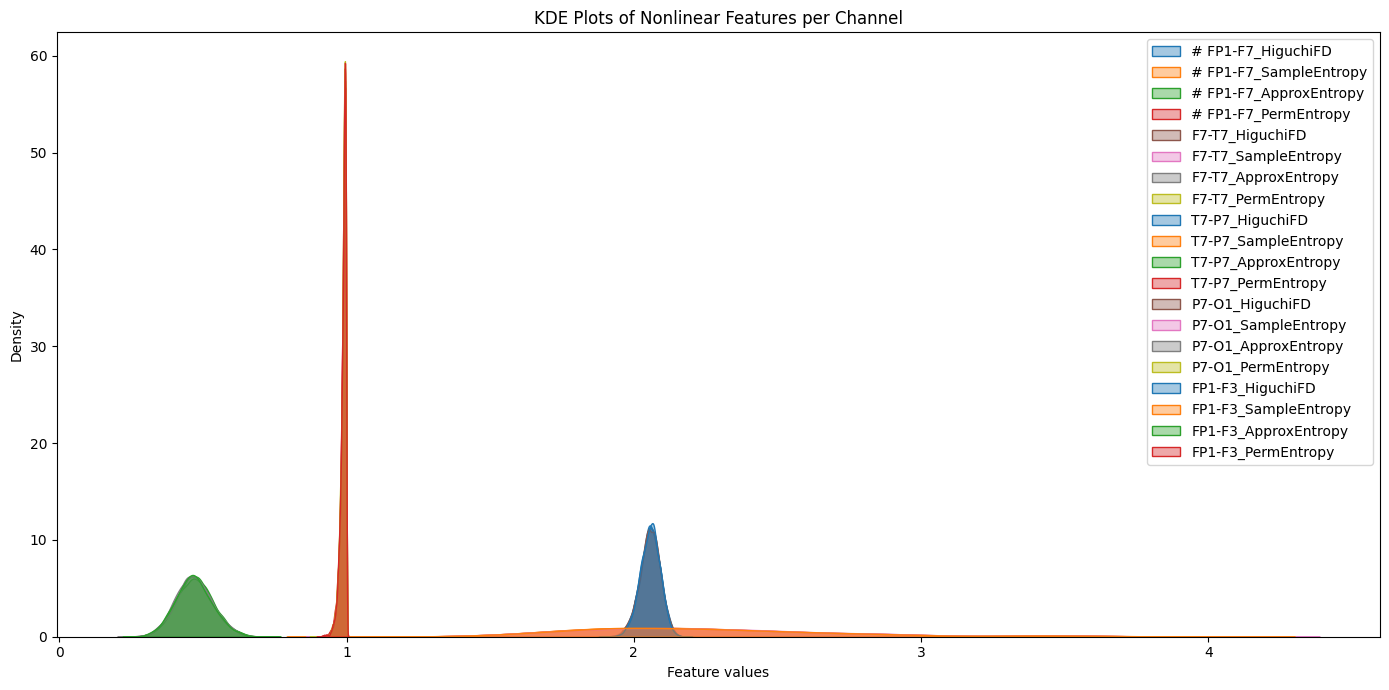

In [10]:
plt.figure(figsize=(14, 7))
for col in features_only.columns:
    sns.kdeplot(features_only[col].dropna(), label=col, fill=True, alpha=0.4)
plt.title('KDE Plots of Nonlinear Features per Channel')
plt.xlabel('Feature values')
plt.legend()
plt.tight_layout()
plt.savefig('kdeplot_nonlinear_features.png')
plt.show()

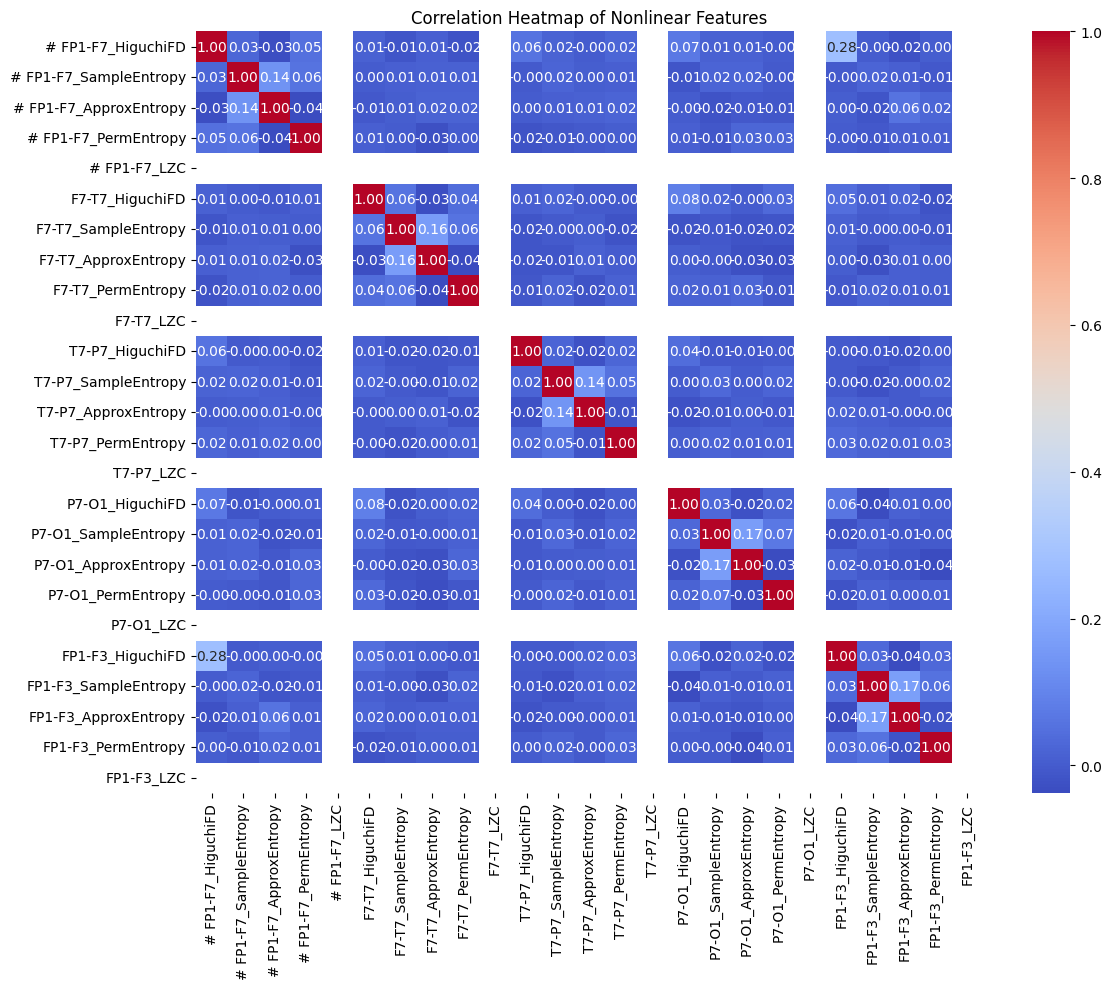

In [11]:
plt.figure(figsize=(12, 10))
corr = features_only.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nonlinear Features')
plt.tight_layout()
plt.savefig('correlation_heatmap_nonlinear_features.png')
plt.show()